In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('table2.csv') 
df.rename(columns={'Patient':'patient',
                     'Days post Infection':'dpi',
                     'vRNA copies/ml':'vRNA', 
                     'IgM (O.D.)':'IgM',
                    'IgG (O.D.)':'IgG'}, inplace=True)

df['log_vRNA'] = np.log10(df['vRNA'])
df

,patient,dpi,vRNA,IgM,IgG,log_vRNA
0,CHID46,13,10910,-,-,4.037825
1,CHID46,16,108100,0.026,0.268,5.033826
2,CHID46,20,800000,0.371,0.354,5.903090
3,CHID46,23,922270,1.927,2.047,5.964858
4,CHID46,27,340400,1.512,2.335,5.531990
...,...,...,...,...,...,...
62,CHID08,19,5631550,0.014,0.175,6.750628
63,CHID08,24,6486240,0.114,0.258,6.811993
64,CHID08,26,2296060,0.795,0.585,6.360983
65,CHID08,31,26311,0.997,1.456,4.420137


In [15]:
df1 = df[['patient','dpi','log_vRNA']]
df2 = df[['patient','dpi','IgM','IgG']].replace('-',np.nan).dropna()
df2[['IgM','IgG']] = df2[['IgM','IgG']].astype(float)

df2['IgM+IgG'] = df2['IgM'] + df2['IgG']


In [16]:
patient_cols = df.patient.unique()
patient_cols

array(['CHID46', 'CHID77', 'CHID79', 'CHID32', 'CHID40', 'CHID08'],
      dtype=object)

[markers](https://matplotlib.org/stable/api/markers_api.html)

[linestyle](https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html)

* T: target cells （CD4$^+$ T cells)
* I: productively infected CD4$^+$ T cells,
* V: free virus

\begin{align}
\frac{dT}{dt} &= \lambda -dT -\beta(t)TV, \quad T(0) =T_0\\
\frac{dI}{dt} &= \beta(t) TV - \delta I,\quad  I(0)= I_0 \\
\frac{dV}{dt} &= pI - cV, \quad V(0) = V_0
\end{align}
where 
\begin{align}
\beta(t) = 
\begin{cases}
\beta_0, \quad t\leq \tau \\
\beta_{\infty} + (\beta_0 - \beta_{\infty}) e^{-k(t-\tau)}, \quad t>\tau
\end{cases}
\end{align}

Determine the parameters $(\beta_0,\beta_{\infty},\lambda, d, \delta, p, c, k, \tau)$ so that it can fit the real data

In this case, we will pick $c=23$, $\lambda =dT_0$, that is 
\begin{align}
\frac{dT}{dt} &= d\cdot(T_0-T) -\beta(t)TV, \quad T(0) =T_0\\
\frac{dI}{dt} &= \beta(t) TV - \delta I,\quad  I(0)= I_0 \\
\frac{dV}{dt} &= pI - 23V, \quad V(0) = V_0
\end{align}

In [17]:
# fT = dT/dt
def fT(lda,d,T,b,V):
    return d*10**4 - d*T - b*T*V

# fI = dI/dt
def fI(b,T,V,dlt,I):
    return b*T*V-dlt*I

# fV = dV/dt
def fV(p,I,c,V):
    return p*I-c*V

def beta(t, tau, k,beta_0,beta_ifty):
    if t <= tau:
        return beta_0
    else:
        return beta_ifty + (beta_0-beta_ifty)*np.exp(-k*(t-tau))

###  Runge-Kutta 4th order 
Solve
$
\frac{dy}{dt} = f(t,y)
$ with $ y(0) = y_0 $
by using
\begin{align}
k_1 &= h f(t_n,y_n) \\
k_2 &= h f(t_n+\frac{h}{2}, y_n + \frac{k_1}{2})\\
k_3 &= h f(t_n+\frac{h}{2}, y_n + \frac{k_2}{2})\\
k_4 &= h f(t_n +h, y_n + k_3) \\
y_{n+1} &= y_n + \frac{1}{6}k_1 + \frac{1}{3}k_2 + \frac{1}{3}k_3+\frac{1}{6}k_4 + O(h^5)
\end{align}


<!-- \begin{align}
T(t+\Delta t) - T(t) &= \Delta t \cdot\big(\lambda - dT(t) - \beta(t) T(t)V(t)\big)\\
I(t+\Delta t) - I(t) &= \Delta t\cdot \big(\beta(t) T(t)V(t) - \delta I(t)\big) \\
V(t+\Delta t) - V(t) &= \Delta t\cdot\big(pI(t) - cV(t)\big)
\end{align} -->

<!-- Backward Euler

\begin{align}
T(t+h) - T(t) &= \lambda - dT(t+h) - \beta(t+h) T(t+h)V(t+h)\\
I(t+h) - I(t) &= \beta(t+h) T(t+h) V(t+h) - \delta I(t+h) \\
V(t+h) - V(t) &= pI(t+h) - cV(t+h)
\end{align} -->

<!-- Then we have 
\begin{align}
T(t+h) - T(t) &= 


\end{align} -->



In [18]:
def runge_kutta_4th(T,I,V,t,h,lda,c,param):
    beta_0 = param[0]
    beta_ifty = param[1] 
    k = param[2] 
    dlt = param[3] 
    p = param[4]
    d = param[5]  
    tau = param[6] 
    
    
    b1 = beta(t,tau,k,beta_0,beta_ifty)
    Tk1 = h*fT(lda,d,T,b1,V)
    Ik1 = h*fI(b1,T,V,dlt,I)
    Vk1 = h*fV(p,I,c,V)
    
    #######################################
    b2 = beta(t+h/2,tau,k,beta_0,beta_ifty)
    T2 = T+Tk1/2
    I2 = I+Ik1/2
    V2 = V+Vk1/2
    
    Tk2 = h*fT(lda,d,T2,b2,V2)
    Ik2 = h*fI(b2,T2,V2,dlt,I2)
    Vk2 = h*fV(p,I2,c,V2)    
    
    #######################################
    b3 = beta(t+h/2,tau,k,beta_0,beta_ifty)
    T3 = T+Tk2/2
    I3 = I+Ik2/2
    V3 = V+Vk2/2
    
    Tk3 = h*fT(lda,d,T3,b3,V3)
    Ik3 = h*fI(b3,T3,V3,dlt,I3)
    Vk3 = h*fV(p,I3,c,V3)    
    
    #######################################
    b4 = beta(t+h,tau,k,beta_0,beta_ifty)
    T4 = T+Tk3/2
    I4 = I+Ik3/2
    V4 = V+Vk3/2
    
    Tk4 = h*fT(lda,d,T4,b4,V4)
    Ik4 = h*fI(b4,T4,V4,dlt,I4)
    Vk4 = h*fV(p,I4,c,V4)
    
    #######################################
    T_new = T+Tk1/6+Tk2/3+Tk3/3+Tk4/6
    I_new = I+Ik1/6+Ik2/3+Ik3/3+Ik4/6
    V_new = V+Vk1/6+Vk2/3+Vk3/3+Vk4/6    
    
    return [max(T_new,0),max(I_new,0),max(V_new,0)]

In [24]:
def predict_v(init, beta_0,beta_ifty, k, dlt, p, d, tau):
    
    # initial value 
    T_0 = init[0] 
    I_0 = init[1]
    V_0 = init[2]
    c = init[3] 
    t_end = init[4]
    h = init[5]
    
    N = int(t_end/h)
    
    lda = d * T_0 
    
    T = N * [T_0]
    I = N * [I_0]
    V = N * [V_0]
    
    param = [beta_0,beta_ifty, k, dlt, p, d, tau]
    
    i = 0
    t = h
    while t < t_end:
        
        T[i+1],I[i+1],V[i+1] = runge_kutta_4th(T[i],I[i],V[i],t,h,lda,c,param)

        i += 1
        t += h
        
    return V

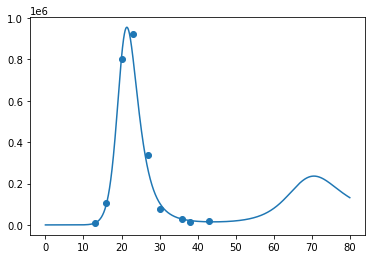

In [26]:
# beta_0,beta_ifty, k, dlt, p, d, tau = 4.2*(10**-7),0.76*(10**-7),0.049,0.812,12.962*(10**3),0.032,11


init = [10**4,0,10**-3,23,80,0.01]

pred = predict_v(init, 4.09*(10**-7), 0.233*(10**-6),0.249, 0.775,14.5*(10**3),0.030,7)
plt.plot(np.arange(0,80.0,0.01),pred)
dg = df.groupby('patient').get_group('CHID46')
plt.scatter(dg.dpi,dg['vRNA'])


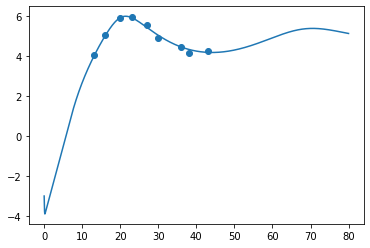

In [27]:
init = [10**4,0,10**-3,23,80,0.01]

pred = np.log10(predict_v(init, 4.09*(10**-7), 0.233*(10**-6),0.249, 0.775,14.5*(10**3),0.030,7))
plt.plot(np.arange(0,80,0.01),pred)
df11 = df1.groupby('patient').get_group('CHID46')
plt.scatter(df11.dpi,df11['log_vRNA'])

In [ ]:
def J(beta_0,beta_infty, k, delta, p, d):
    return 1/N * sum(([np.log10(V[i]) -np.log10(V_true[i])**2 for i in range(N)])   